In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

C:\Users\joaquin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<class 'pandas.core.frame.DataFrame'>
(144, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60    144 non-null int64
dtypes: int64(1)
memory usage: 1.2 KB
None
(144, 1)
(96, 1)
(48, 1)
(94, 1, 1) (94,)
(46, 1, 1) (46,)
Epoch 1/100
 - 2s - loss: 0.0414
Epoch 2/100
 - 1s - loss: 0.0202
Epoch 3/100
 - 1s - loss: 0.0145
Epoch 4/100
 - 1s - loss: 0.0131
Epoch 5/100
 - 1s - loss: 0.0121
Epoch 6/100
 - 1s - loss: 0.0111
Epoch 7/100
 - 1s - loss: 0.0102
Epoch 8/100
 - 1s - loss: 0.0093
Epoch 9/100
 - 1s - loss: 0.0081
Epoch 10/100
 - 1s - loss: 0.0071
Epoch 11/100
 - 1s - loss: 0.0062
Epoch 12/100
 - 1s - loss: 0.0053
Epoch 13/100
 - 1s - loss: 0.0045
Epoch 14/100
 - 1s - loss: 0.0038
Epoch 15/100
 - 1s - loss: 0.0033
Epoch 16/100
 - 1s - loss: 0.0029
Epoch 17/100
 - 1s - loss: 0.0026
Epoch 18/100
 - 1s - loss: 0.0024
Epoch 19/100
 - 1s - loss: 0.0022
Epoch 20/

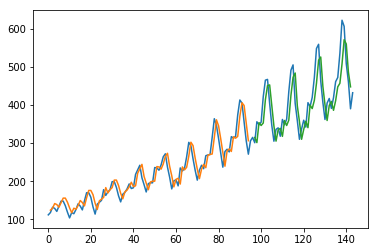

In [2]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = read_csv('..\\..\\Datos\\international-airline-passengers.csv', 
                     usecols=[1], engine='python', skipfooter=3)
print(type(dataframe))
print(dataframe.shape)
print(dataframe.info())
dataframe.head()

dataset = dataframe.values
dataset = dataset.astype('float32')
print(dataset.shape)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset.shape

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape)
print(test.shape)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

# LSTM Network for Regression

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(trainPredict.shape)
print(testPredict.shape)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

print(trainPredict.shape,trainY.shape)
print(testPredict.shape,testY.shape)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()